# Import

In [1]:
# Hanlde dataframes and math
import pandas as pd
import numpy as np

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# plot 
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score


# Functions

In [2]:

from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



# Data management

In [3]:
#upload the dataset by downloading both datasets from canvas and upload it on colab

data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")
data_df.head(289)

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
284,"E4S 56,780",20210101,23:40:00,23:45:00,284,20.73,43
285,"E4S 56,780",20210101,23:45:00,23:50:00,285,20.71,32
286,"E4S 56,780",20210101,23:50:00,23:55:00,286,19.54,39
287,"E4S 56,780",20210101,23:55:00,24:00:00,287,19.93,34


In [4]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


(288,)


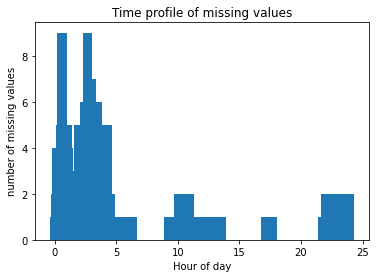

In [5]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('Hour of day')
ax.set_title('Time profile of missing values')

plt.show()

number of days with missing value 28


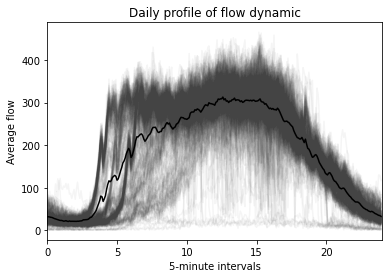

In [6]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),vectorized_day_dataset.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_day_dataset,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Average flow')
ax.set_xlabel('5-minute intervals')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')

plt.show()

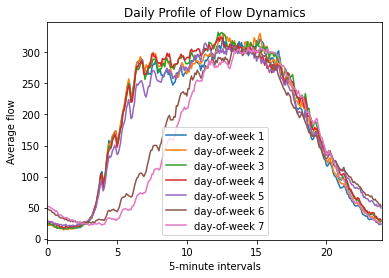

In [7]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    
    ax.plot(x_axis_hours,
            np.nanmean(vectorized_day_dataset[day_of_week_index_t[0], :].transpose(), 1),
            label='day-of-week ' + str(i))
    # This line plots the average flow for the current day of the week.
    # 'np.nanmean()' calculates the mean while handling NaN values.

# Set the y-axis label
ax.set_ylabel('Average flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics')

# Add a legend indicating the day of the week
ax.legend()
# Display the plot
plt.show()

# K Means

cluster_id_weekdays_share [94, 8, 134]
cluster_id_weekend_share [26, 75, 0]
111


/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_21637/3807114047.py:166: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("spring").copy()
  cmap.set_bad(color='white')


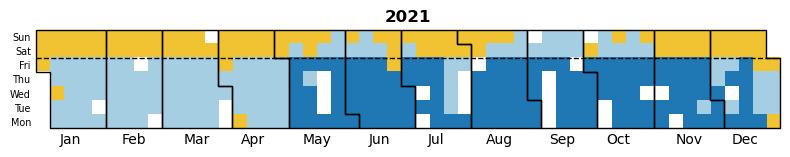

Silhouette Score: 0.2692406087798076
Davies-Bouldin Score: 1.3587890766043216
Calinski-Harabasz Score: 159.13421302277044


In [8]:
n_clusters = 3
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
cluster_labels = clusters.labels_

n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

# Agglomeratice Clustering

cluster_id_weekdays_share [71, 3, 90, 33, 8, 5, 5, 17, 3, 1]
cluster_id_weekend_share [0, 44, 0, 0, 11, 0, 42, 0, 2, 2]
111


/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_21637/3807114047.py:166: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("spring").copy()
  cmap.set_bad(color='white')


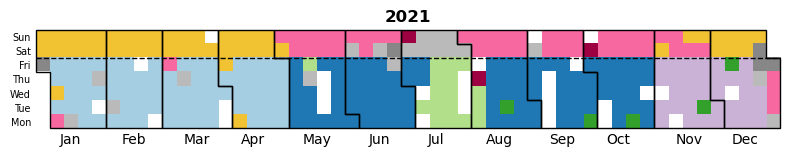

Silhouette Score: 0.21506167345844876
Davies-Bouldin Score: 1.4150683146774554
Calinski-Harabasz Score: 78.95519615286356


In [9]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
cluster_labels = clusters.labels_

n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

# DB Scan

cluster_id_weekdays_share [2, 37, 3, 32, 14, 3, 145]
cluster_id_weekend_share [44, 0, 35, 0, 0, 0, 22]
111


/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_21637/3807114047.py:166: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("spring").copy()
  cmap.set_bad(color='white')


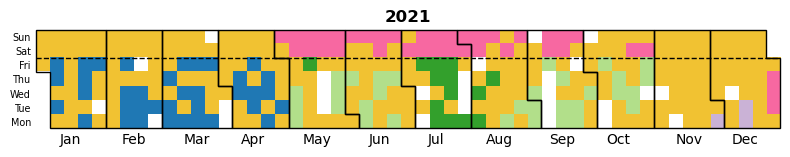

Silhouette Score: -0.02772100330028316
Davies-Bouldin Score: 2.3795720914163363
Calinski-Harabasz Score: 35.327906331751436


In [10]:
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = DBSCAN(eps=500, min_samples = 3).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
cluster_labels = clusters.labels_

n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

# Gaussian mixture

cluster_id_weekdays_share [56, 6, 69, 1, 22, 4, 35, 10, 1, 32]
cluster_id_weekend_share [0, 43, 0, 1, 0, 43, 0, 12, 2, 0]
111


/var/folders/vv/61p1g2195ln_91592fly3yk40000gn/T/ipykernel_21637/3807114047.py:166: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("spring").copy()
  cmap.set_bad(color='white')


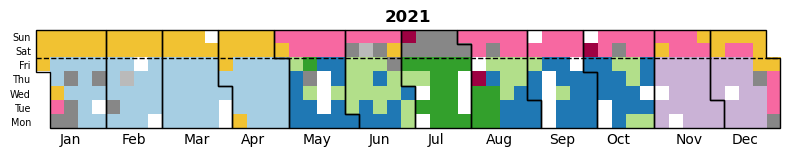

Silhouette Score: 0.20336413103471754
Davies-Bouldin Score: 1.6619784599023362
Calinski-Harabasz Score: 78.10316805919132


In [11]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py

# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)

# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)